# Structural Estimation 
# PS3
# Jose Cerda

# 1. Matching the U.S. income distribution by GMM

# a) Create the moments in Table 1

In [254]:
# Import the necessary libraries
import numpy.linalg as lin
import scipy.integrate as intgr
import numpy as np
import scipy.stats as sts
import requests
import statistics
import matplotlib.pyplot as plt
import pandas as pd
import scipy.special as spc
import os
import random
import scipy.optimize as opt

In [255]:
# Import the data
hh_inc = np.loadtxt('hh_inc_synth.txt')
random.seed(100)

In [256]:
#Statistics about HH income that may be useful
n = len(hh_inc)
mu = statistics.mean(hh_inc)
med = statistics.median(hh_inc)
maxi = max(hh_inc)
mini = min(hh_inc)
sigma = statistics.stdev(hh_inc)
  
# Report
print ("Statistics of House Hold Income (Dollars)")
print("N:", n)
print("Mean:", mu)
print("Median:", med)
print("Maximum:", maxi)
print("Minimum:", mini)
print("Stdev:", sigma)

Statistics of House Hold Income (Dollars)
N: 121085
Mean: 67269.598228936
Median: 50090.02535461736
Maximum: 349978.7695007046
Minimum: 1.0830783075610473
Stdev: 60632.54140840025


In [257]:
#Create the first 40 bins
hist1, bin_edges1 = np.histogram(hh_inc, bins=40, range=(0, 200000))

In [258]:
#Create the other bins
hist2, bin_edges2 = np.histogram(hh_inc, bins=(200000, 250000, 350000), range=(200000, 350000))

In [259]:
#Merge two arrays of hist data and edges
hist_dt = np.append(hist1, hist2)
bin_edges_dt = np.append(bin_edges1, bin_edges2)
print('Histogram data', hist_dt)
print('Bin edges', bin_edges_dt)

Histogram data [4261 4972 7127 6882 7095 6591 6667 6136 5795 4945 5170 4250 4432 3836
 3606 3452 3036 2566 2594 2251 2527 1771 1723 1569 1540 1258 1211  918
 1031  893 1166  740  697  610  617  530  460  363  380  312 2297 2808]
Bin edges [     0.   5000.  10000.  15000.  20000.  25000.  30000.  35000.  40000.
  45000.  50000.  55000.  60000.  65000.  70000.  75000.  80000.  85000.
  90000.  95000. 100000. 105000. 110000. 115000. 120000. 125000. 130000.
 135000. 140000. 145000. 150000. 155000. 160000. 165000. 170000. 175000.
 180000. 185000. 190000. 195000. 200000. 200000. 250000. 350000.]


# b) Plot the histogram of the data and the height being the percent of observations in that bin and not the count frequency. List the dollar amounts on the x-axis as thousands of dollars

In [260]:
#Put variables in thousands
hh_inc_th = hh_inc/1000
bin_edges_dt_th = bin_edges_dt/1000

In [261]:
#Weights
from collections import Counter

weights = [0]*len(hh_inc_th)
for w in range(0,len(weights)):
    #now write so it gets corresponding widths
        if hh_inc_th[w] <= 199.999:
            weights[w] = 1/(len(hh_inc_th) * 5)
        if hh_inc_th[w] <= 249.999 and hh_inc_th[w] >= 200 :
            weights[w] = 1/(len(hh_inc_th) * 50)
        if hh_inc_th[w] >= 250:
            weights[w] = 1/(len(hh_inc_th) * 100)
            
#check that weights calculated correctly by identifying 3 unique weights
Counter(weights).keys()

dict_keys([1.651732254201594e-06, 8.258661271007969e-08, 1.6517322542015938e-07])

Text(0, 0.5, 'Density')

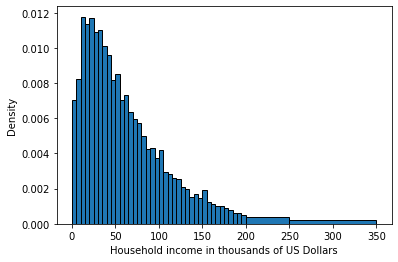

In [262]:
#Plot the histogram
hist_vals = plt.hist(hh_inc_th, bin_edges_dt_th, weights = weights, edgecolor = 'black')
plt.xlabel('Household income in thousands of US Dollars')
plt.ylabel('Density')

# c) Using GMM, fit the lognormal LN distribution defined in the MLE notebook to the distribution of household income data using the moments from the data file

In [263]:
# Define LN dist
def ln_norm_pdf(xvals, mu, sigma):
    pdf_vals = ((1/(xvals * sigma * np.sqrt(2 * np.pi))) * np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2)))
    pdf_vals[pdf_vals < 1e-10] = 1e-10
    return pdf_vals

In [264]:
#Define data moments
def data_moments(xvals):
    mom_data = hist_dt/n
    
    return mom_data    

In [265]:
#Define the model moments 
def ln_moments(mu, sigma, n, bins):
    x = np.linspace(min(bins), max(bins), max(bins)+1)
    pdf_calc = ln_norm_pdf(x[1:], mu, sigma)
    mom_model = []
    for i in range(len(bins)-1):
        y = pdf_calc[bins[i] : bins[i+1]]
        mom_model.append(np.sum(y))
    mom_model = np.array(mom_model)
    
    return mom_model

In [266]:
#Define the error vector 
def err_vec_ln(xvals, mu, sigma, n, bins, simple):
    moms_data = data_moments(xvals)
    moms_model = ln_moments(mu, sigma, n, bins)
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [267]:
#Define criterion function
def criterion_ln(params, *args):
    mu, sigma = params
    xvals, W, n, bins = args
    err = err_vec_ln(xvals, mu, sigma, n, bins, simple=True)
    crit_val = err.T @ W @ err
    
    return crit_val

In [268]:
#Estimate through GMM
#Initial guesses
bins_th = [i for i in range(0, 200+1, 5)] + [250, 350]
mu_init = np.mean(np.log(hh_inc_th))
sigma_init = np.std(np.log(hh_inc_th))
params_init = np.array([mu_init, sigma_init])

print('mu_init=', mu_init, 'sigma_init', sigma_init)

#Weighting matrix
W_hat = np.eye(42) 
row,col = np.diag_indices(W_hat.shape[0])
W_hat[row,col] =  data_moments(hh_inc_th)
#W_hat[row,col] =  data_moments(hh_inc)
gmm_args = (hh_inc_th, W_hat, n, bins_th)

#Optimize L-BFGS-B
results_ln = opt.minimize(criterion_ln, params_init, args=(gmm_args), tol=1e-14, method='TNC', bounds=((1e-10, None), (1e-10, None)))
mu_GMM_ln, sigma_GMM_ln = results_ln.x
print('mu_GMM_ln=', mu_GMM_ln, ' sigma_GMM_ln=', sig_GMM_ln)
results

mu_init= 3.780552299347908 sigma_init 1.0610439509283802
mu_GMM_ln= 3.9585128914883976  sigma_GMM_ln= 1.027996598600394


     fun: 121083.00001876864
     jac: array([0.00145519, 0.00145519])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 14
     nit: 2
  status: 1
 success: True
       x: array([2.99999295e+00, 2.00000000e+04])

In [270]:
#Criterion function value
print("crit_val_ln=", results_ln.fun)

crit_val_ln= 3.134397343349639e-05


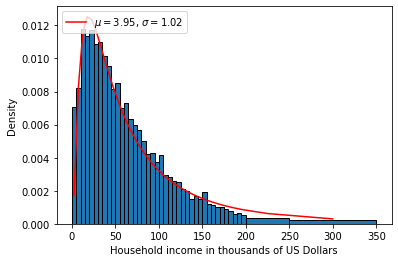

In [271]:
#Histogram and LN
hist_vals = plt.hist(hh_inc_th, bins_th, weights = weights, edgecolor = 'black')
plt.xlabel('Household income in thousands of US Dollars')
plt.ylabel('Density')

mid_vals = []
i = 0
for i in range(42):
    j = (bins_th[i+1]/2 - bins_th[i]/2 + bins_th[i])
    mid_vals.append(j)
    i+=1
    
mid_vals = np.asarray(mid_vals)
hist_ln = ln_norm_pdf(mid_vals, mu_GMM_ln, sigma_GMM_ln)
plt.plot(mid_vals, hist_ln, color = 'r', label = '$\mu =3.95 $, $\sigma =1.02 $')
plt.legend(loc='upper left')


# d) Using GMM, fit the gamma GA to the distribution of household income data using the moments from the data file.

In [272]:
#Define a GA pdf
def gamma_ga_pdf(xvals, alpha, beta): 
    gamma_arg = spc.gamma(alpha)
    pdf_vals = (1/((beta**alpha) *gamma_arg))*(xvals**(alpha-1))*(np.exp(-(xvals/beta)))
    pdf_vals[pdf_vals < 1e-10] = 1e-10
    return pdf_vals

In [273]:
#Define data moments
def data_moments(xvals):
    mom_data = hist_dt/n
    
    return mom_data

In [274]:
#Define the model moments 
def ga_moments(alpha, beta, n, bins):
    x = np.linspace(min(bins), max(bins), max(bins)+1)
    pdf_calc = gamma_ga_pdf(x[1:], alpha, beta)
    mom_model = []
    for i in range(len(bins)-1):
        y = pdf_calc[bins[i] : bins[i+1]]
        mom_model.append(np.sum(y))
    mom_model = np.array(mom_model)
    
    return mom_model

In [275]:
#Define the error vector 
def err_vec_ga(xvals, alpha, beta, n, bins, simple):
    moms_data = data_moments(xvals)
    moms_model = ga_moments(alpha, beta, n, bins)
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [276]:
#Define criterion function
def criterion_ga(params, *args):
    alpha, beta = params
    xvals, W, n, bins = args
    err = err_vec_ga(xvals, alpha, beta, n, bins, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [277]:
#Estimate through GMM
#Initial guesses
bins_th = [i for i in range(0, 200+1, 5)] + [250, 350]
alpha_init = 3 
beta_init = 20000
params_init = np.array([alpha_init, beta_init])
print('alpha_init', alpha_init, 'beta_init', beta_init)

#Weighting matrix
W_hat = np.eye(42) 
row,col = np.diag_indices(W_hat.shape[0])
W_hat[row,col] =  data_moments(hh_inc_th)
gmm_args = (hh_inc_th, W_hat, n, bins_th)

#Optimize L-BFGS-B
results_ga = opt.minimize(criterion_ga, params_init, args=(gmm_args), tol=1e-14, method='TNC', bounds=((1e-10, None), (1e-10, None)))
alpha_GMM_ga, beta_GMM_ga = results_ga.x
print('alpha_GMM_ga=', alpha_GMM_ga, ' beta_GMM_ga=', beta_GMM_ga)
results

alpha_init 3 beta_init 20000
alpha_GMM_ga= 0.3925867045355931  beta_GMM_ga= 1588.4832367807576


     fun: 121083.00001876864
     jac: array([0.00145519, 0.00145519])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 14
     nit: 2
  status: 1
 success: True
       x: array([2.99999295e+00, 2.00000000e+04])

In [278]:
#Criterion function value
print("crit_val_ga=", results_ga.fun)

crit_ga 0.5169734451348891
crit_val_ga= 0.5169734451348891


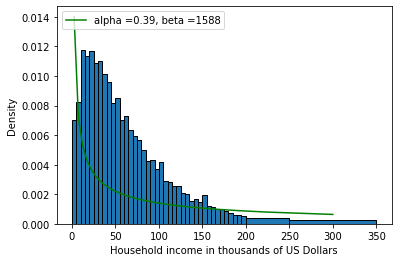

In [279]:
#Histogram and GA
hist_vals = plt.hist(hh_inc_th, bins_th, weights = weights, edgecolor = 'black')
plt.xlabel('Household income in thousands of US Dollars')
plt.ylabel('Density')

#GA
hist_ga = gamma_ga_pdf(mid_vals, alpha_GMM_ga, beta_GMM_ga)
plt.plot(mid_vals, hist_ga, color = 'g', label = 'alpha =0.39, beta =1588')
plt.legend(loc='upper left')

# e) Plot the histogram from part (a) overlayed with the line representing the implied histogram from your estimated lognormal (LN) distribution from part (b) and the line representing the implied histogram from your estimated gamma (GA) distribution from part (c).

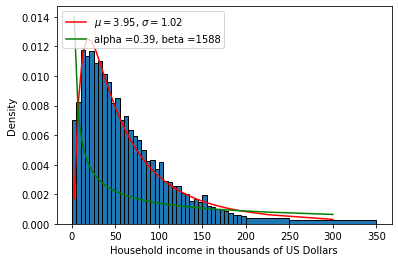

In [280]:
#Histogram and GA
hist_vals = plt.hist(hh_inc_th, bins_th, weights = weights, edgecolor = 'black')
plt.xlabel('Household income in thousands of US Dollars')
plt.ylabel('Density')

#LN
hist_ln = ln_norm_pdf(mid_vals, mu_GMM_ln, sigma_GMM_ln)
plt.plot(mid_vals, hist_ln, color = 'r', label = '$\mu =3.95 $, $\sigma =1.02 $')

#GA
hist_ga = gamma_ga_pdf(mid_vals, alpha_GMM_ga, beta_GMM_ga)
plt.plot(mid_vals, hist_ga, color = 'g', label = 'alpha =0.39, beta =1588')
plt.legend(loc='upper left')

# Which estimated distribution LN or GA fits the data best?

In [281]:
#Comparison
print('To the naked eye, LN seems to do a better job, however the criterion functions say otherwise.')

To the naked eye, LN seems to do a better job, however the criterion functions say otherwise.


# f) Repeat your estimation of the GA distribution from part (c), but use the two-step estimator for the optimal weighting matrix

In [282]:
#Two-step optimal weighting matrix
def get_Err_mat2(xvals, alpha, beta, n, bins, simple=False):

    R = 42
    N = len(xvals)
    Err_mat = np.zeros((R, N))
    moms_model1 = ga_moments(alpha, beta, n, bins)
    moms_data1 = data_moments(xvals)
    if simple:
        for i in range(0, len(moms_data1)):
            Err_mat[i, :] = moms_data1[i] - moms_model1[i]
    else:
        for i in range(0, len(moms_data1)):
            Err_mat[i, :] = (moms_data1[i] - moms_model1[i])/moms_model1[i]
    
    return Err_mat

In [283]:
#Compute the error matrix
Err_mat = get_Err_mat2(hh_inc_th, alpha_GMM_ga, beta_GMM_ga, n, bins, False)
VCV2 = (1 / hh_inc_th.shape[0]) * (Err_mat @ Err_mat.T)
#print(VCV2)
W_hat2 = lin.inv(VCV2)
#print(W_hat2)

In [284]:
#Estimate through GMM
#Initial guesses
alpha_init = alpha_GMM_ga #3 #1.36 #3 
beta_init = beta_GMM_ga #20000 #48063 #20000
params_init = np.array([alpha_init, beta_init])

#Weighting matrix
gmm_args = (hh_inc_th, W_hat2, n, bins_th)

#Optimize L-BFGS-B
results_ga2 = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14, method='TNC', bounds=((1e-10, None), (1e-10, None)))
alpha_GMM_ga2, beta_GMM_ga2 = results_ga2.x
print('alpha_GMM_ga2=', alpha_GMM_ga2, ' beta_GMM_ga2=', beta_GMM_ga2)
results

alpha_GMM_ga2= 0.2794627164317416  beta_GMM_ga2= 5223.71443731701


     fun: 121083.00001876864
     jac: array([0.00145519, 0.00145519])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 14
     nit: 2
  status: 1
 success: True
       x: array([2.99999295e+00, 2.00000000e+04])

In [285]:
#Criterion function value
print("crit_val_ga2=", results_ga2.fun)

crit_val_ga2= -368044921515133.6


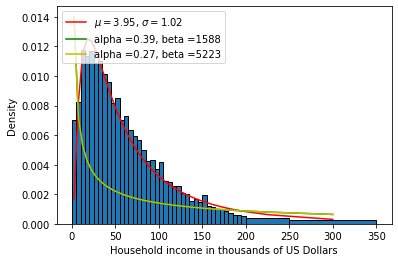

In [286]:
#Histogram and GA
hist_vals = plt.hist(hh_inc_th, bins_th, weights = weights, edgecolor = 'black')
plt.xlabel('Household income in thousands of US Dollars')
plt.ylabel('Density')

#LN
hist_ln = ln_norm_pdf(mid_vals, mu_GMM_ln, sigma_GMM_ln)
plt.plot(mid_vals, hist_ln, color = 'r', label = '$\mu =3.95 $, $\sigma =1.02 $')

#GA
hist_ga = gamma_ga_pdf(mid_vals, alpha_GMM_ga, beta_GMM_ga)
plt.plot(mid_vals, hist_ga, color = 'g', label = 'alpha =0.39, beta =1588')
plt.legend(loc='upper left')

#GA2
hist_ga2 = gamma_ga_pdf(mid_vals, alpha_GMM_ga2, beta_GMM_ga2)
plt.plot(mid_vals, hist_ga, color = 'y', label = 'alpha =0.27, beta =5223')
plt.legend(loc='upper left')

# 2. Estimating the Brock and Mirman (1972) model by GMM

In [287]:
from pandas import DataFrame
from pandas import concat

In [288]:
#Import data
macroseries = np.loadtxt('MacroSeries.txt', delimiter=',')

In [289]:
#Reshape data
c = macroseries[:,[0]]
k = macroseries[:,[1]]
w = macroseries[:,[2]]
r = macroseries[:,[3]]
print('c4',c[4],'k4',k[4],'w4',w[4],'r4',r[4])

c4 [8140994.1833072] k4 [5632135.94271214] w4 [8082465.98137312] r4 [1.03918305]


In [290]:
#Initial parameters
alpha_0=0.3
beta_0=0.99
rho_0=0.4
mu_0=0.7
sigma_0=0.6
err_mu_0=0

x_0=4

#Parameters
alpha=alpha_0
beta=beta_0
rho=rho_0
mu=mu_0
sigma=sigma_0

#print(x_0)

# a) Estimate by GMM using the unconditional moment conditions. Assume beta = 0.99. Use the identity matrix I(4) as your estimator of the optimal weighting matrix.

In [291]:
#Define data moments
def data_moments(xvals):
    
    m1_data = 0
    m2_data = 0
    m3_data = 0
    m4_data = 0
    
    return m1_data, m2_data, m3_data, m4_data   

In [292]:
#Define model moments
def model_moments(c, k, w, r, alpha, beta, mu, rho):
    
    #Compute z and z[t+1] and z[t-1]
    z = np.log((r/alpha) * (k)**(1-alpha))
    values = DataFrame(z)
    dataframe = concat([values.shift(1), values], axis=1)
    dataframe.columns = ['t-1', 't+1']
    zlag = values.shift(1)
    zfro = values.shift(-1)
    
    #Compute k[t+1]
    values2 = DataFrame(k)
    dataframe2 = concat([values2.shift(-1), values2], axis=1)
    dataframe2.columns = ['t-1', 't+1']
    kfro = values2.shift(-1)
    
    #Compute c[t+1]
    values3 = DataFrame(c)
    dataframe3 = concat([values3.shift(-1), values3], axis=1)
    dataframe3.columns = ['t-1', 't+1']
    cfro = values3.shift(-1)

    #Compute model moments
    m1_mod_df = (zfro-rho*z-(1-rho)*mu)
    m2_mod_df = ((zfro-rho*z-(1-rho)*mu)*z)
    m3_mod_df = (beta*alpha*np.exp(zfro)*(kfro**(alpha-1))*(c/cfro)-1)
    m4_mod_df = ((beta*alpha*np.exp(zfro)*(kfro**(alpha-1))*(c/cfro)-1)*w)
    
    #Compute expectations of the df moments
    sum_m1 = m1_mod_df.sum().iloc[0]
    sum_m2 = m2_mod_df.sum().iloc[0]
    sum_m3 = m3_mod_df.sum().iloc[0]
    sum_m4 = m4_mod_df.sum().iloc[0]
    m1_mod = sum_m1/100
    m2_mod = sum_m2/100
    m3_mod = sum_m3/100
    m4_mod = sum_m4/100
    
    return m1_mod, m2_mod, m3_mod, m4_mod
    

In [293]:
#Define the error vector 
def err_vec_gmm(xvals, c, k, w, r, alpha, beta, mu, sigma, rho, simple):
    m1_data, m2_data, m3_data, m4_data = data_moments(xvals)
    moms_data = np.array([[m1_data], [m2_data], [m3_data], [m4_data]])
    m1_mod, m2_mod, m3_mod, m4_mod = model_moments(c, k, w, r, alpha, beta, mu, rho)
    moms_model = np.array([[m1_mod], [m2_mod], [m3_mod], [m4_mod]])
    
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [294]:
#Define criterion function
def crit_gmm(params, *args):
    alpha, beta, mu, sigma, rho = params
    xvals, c, k, w, r, W = args
    err = err_vec_gmm(xvals, c, k, w, r, alpha, beta, mu, sigma, rho, simple=True)
    crit_val = err.T @ W @ err
    
    return crit_val

In [303]:
#Estimate through GMM
import scipy.optimize as opt

x_0=4
alpha_init=0.3
beta_init=0.99
mu_init=0.7
sigma_init=0.5
rho_init=0.4

params_init = np.array([alpha_init, beta_init, mu_init, sigma_init, rho_init])
W_hat = np.eye(4)
gmm_args = (x_0, c, k, w, r, W_hat)
results_gmm = opt.minimize(crit_gmm, params_init, args=(gmm_args), tol=1e-14, method='L-BFGS-B', bounds=((1e-10, 1-(1e-10)), (1e-10, 1-(1e-10)), (1e-10, None), (1e-10, None), (-1+(1e-10), 1-(1e-10))))
(alpha_gmm, beta_gmm, mu_gmm, sigma_gmm, rho_gmm) = results_gmm.x

print('alpha_gmm=', alpha_gmm, 'beta_gmm=', beta_gmm, 'mu_gmm', mu_gmm, 'sima_gmm', sigma_gmm, 'rho_gmm', rho_gmm)
results_gmm

alpha_gmm= 0.3067279781560769 beta_gmm= 0.9899999950004615 mu_gmm 12.152869909890455 sima_gmm 0.5 rho_gmm 0.40567841731630955


      fun: array([[0.00271226]])
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.11675465e-02,  1.00166369e+02, -4.93612378e-03,  0.00000000e+00,
        1.69959966e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 324
      nit: 7
   status: 0
  success: True
        x: array([ 0.30672798,  0.99      , 12.15286991,  0.5       ,  0.40567842])

In [301]:
#Criterion value
print('crit_val_gmm', results_gmm.fun)

crit_val_gmm [[0.00271226]]


# b) Compute the two-step GMM estimator and use the finite difference Jacobian method for the estimator of the variance-covariance of the two-step GMM point estimates

In [ ]:
def Jac_err4(xvals, c, k, w, r, alpha, beta, mu, sigma, rho, simple=True):
    '''
    This function computes the Jacobian matrix of partial derivatives of the R x 1 moment
    error vector e(x|theta) with respect to the K parameters theta_i in the K x 1 parameter vector
    theta. The resulting matrix is R x K Jacobian.
    '''
    Jac_err = np.zeros((4, 5))
    h_alpha = 1e-8 * alpha
    h_beta = 1e-8 * beta
    h_mu = 1e-8 * mu
    h_sig = 1e-8 * sigma
    h_rho = 1e-8 * rho
    Jac_err[:, 0] = \
        ((err_vec4(xvals, mu + h_mu, sigma, cut_lb, cut_ub, simple) -
          err_vec4(xvals, mu - h_mu, sigma, cut_lb, cut_ub, simple)) / (2 * h_mu)).flatten()
    Jac_err[:, 1] = \
        ((err_vec4(xvals, mu, sigma + h_sig, cut_lb, cut_ub, simple) -
          err_vec4(xvals, mu, sigma - h_sig, cut_lb, cut_ub, simple)) / (2 * h_sig)).flatten()
    
    return Jac_err

In [ ]:
N = pts.shape[0]
d_err2 = Jac_err2(pts, mu_GMM1, sig_GMM1, 0.0, 450.0, False)
print(d_err2)
print(W_hat)
SigHat2 = (1 / N) * lin.inv(d_err2.T @ W_hat @ d_err2)
print(SigHat2)
print('Std. err. mu_hat=', np.sqrt(SigHat2[0, 0]))
print('Std. err. sig_hat=', np.sqrt(SigHat2[1, 1]))